In [1]:

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
data_path = Path("../data")







In [2]:
# Note the Capital Letters and correct filenames
TRAIN_PATH = data_path / "Train.csv"
TEST_PATH  = data_path / "Test.csv"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

train.shape, test.shape


((29132, 29), (10000, 29))

In [3]:
PROFILE_COLS = [
    "ID","join_date","sex","marital_status","birth_year",
    "branch_code","occupation_code","occupation_category_code"
]
PRODUCT_COLS = [c for c in train.columns if c not in PROFILE_COLS]

assert len(PRODUCT_COLS) == 21, f"Attendu 21 produits, trouvé {len(PRODUCT_COLS)}"



In [4]:
PROFILE_COLS

['ID',
 'join_date',
 'sex',
 'marital_status',
 'birth_year',
 'branch_code',
 'occupation_code',
 'occupation_category_code']

In [5]:
 PRODUCT_COLS

['P5DA',
 'RIBP',
 '8NN1',
 '7POT',
 '66FJ',
 'GYSR',
 'SOP4',
 'RVSZ',
 'PYUQ',
 'LJR9',
 'N2MW',
 'AHXO',
 'BSTQ',
 'FM3X',
 'K6QO',
 'QBOL',
 'JWFN',
 'JZ9D',
 'J9JW',
 'GHYX',
 'ECY3']



Dans ce dataset, il n’y a pas de colonne “TARGET”. Le test est construit comme “train moins 1 produit” : un produit détenu est masqué (passé à 0).  
Donc, pour entraîner et évaluer correctement, nous devons simuler ce masquage sur le train : sinon, on optimise un mauvais problème.


In [6]:
checks = {
    "train_id_unique": train["ID"].is_unique,
    "test_id_unique": test["ID"].is_unique,
    "train_duplicates_rows": int(train.duplicated().sum()),
    "test_duplicates_rows": int(test.duplicated().sum()),
    "id_intersection_train_test": len(set(train["ID"]).intersection(set(test["ID"]))),
}
checks


{'train_id_unique': True,
 'test_id_unique': True,
 'train_duplicates_rows': 0,
 'test_duplicates_rows': 0,
 'id_intersection_train_test': 0}

In [7]:
missing_train = train.isna().sum().sort_values(ascending=False)
missing_test  = test.isna().sum().sort_values(ascending=False)

missing_train.head(15)


join_date                   2
ID                          0
sex                         0
marital_status              0
birth_year                  0
branch_code                 0
occupation_code             0
occupation_category_code    0
P5DA                        0
RIBP                        0
8NN1                        0
7POT                        0
66FJ                        0
GYSR                        0
SOP4                        0
dtype: int64

In [8]:
missing_test.head(15)

join_date                   1
ID                          0
sex                         0
marital_status              0
birth_year                  0
branch_code                 0
occupation_code             0
occupation_category_code    0
P5DA                        0
RIBP                        0
8NN1                        0
7POT                        0
66FJ                        0
GYSR                        0
SOP4                        0
dtype: int64

In [9]:
prod_minmax = {
    "train_min": int(train[PRODUCT_COLS].min().min()),
    "train_max": int(train[PRODUCT_COLS].max().max()),
    "test_min": int(test[PRODUCT_COLS].min().min()),
    "test_max": int(test[PRODUCT_COLS].max().max()),
    "nunique_each_product_train": train[PRODUCT_COLS].nunique().to_dict(),
}
prod_minmax


{'train_min': 0,
 'train_max': 1,
 'test_min': 0,
 'test_max': 1,
 'nunique_each_product_train': {'P5DA': 2,
  'RIBP': 2,
  '8NN1': 2,
  '7POT': 2,
  '66FJ': 2,
  'GYSR': 2,
  'SOP4': 2,
  'RVSZ': 2,
  'PYUQ': 2,
  'LJR9': 2,
  'N2MW': 2,
  'AHXO': 2,
  'BSTQ': 2,
  'FM3X': 2,
  'K6QO': 2,
  'QBOL': 2,
  'JWFN': 2,
  'JZ9D': 2,
  'J9JW': 2,
  'GHYX': 2,
  'ECY3': 2}}

## Test clé : “test ressemble à train moins 1 produit”

Si le test est bien “train moins 1 produit”, alors le nombre de produits à 1 (basket_size) doit être plus faible en test, typiquement d’environ 1 en moyenne.  
Ce check est critique : si ce test échoue, tout le framing du projet est probablement faux.


In [10]:
train_basket = train[PRODUCT_COLS].sum(axis=1)
test_basket  = test[PRODUCT_COLS].sum(axis=1)

summary = pd.DataFrame({
    "train": train_basket.describe(),
    "test": test_basket.describe()
})
summary


,train,test
count,29132.000000,10000.00000
mean,2.277667,1.28530
std,0.602677,0.59088
min,2.000000,1.00000
25%,2.000000,1.00000
50%,2.000000,1.00000
75%,2.000000,1.00000
max,14.000000,7.00000


In [11]:
mean_gap = float(train_basket.mean() - test_basket.mean())
mean_gap


0.9923671701222021

In [12]:
assert (train_basket >= 1).all(), "Train: clients avec 0 produit (inattendu)."
assert (test_basket  >= 1).all(), "Test: clients avec 0 produit (incompatible avec masking 1 produit)."


In [13]:
int((train_basket == 1).sum())



0

In [14]:
int((test_basket == 1).sum())


7685

In [15]:
int((train_basket == 2).sum())


22732

In [16]:
int((test_basket == 1).sum())

7685

L’écart moyen train–test vaut ≈ 0.99 : c’est exactement ce qu’on attend si, en moyenne, le test correspond à un panier identique au train mais avec un produit détenu masqué.  
Conclusion : notre hypothèse “basket completion” est cohérente avec la construction du dataset, donc on peut continuer avec un protocole d’entraînement basé sur le masquage.


##  Nettoyage des données

Même si l’EDA est “exploratoire”, notre objectif est un projet production-ready : les transformations doivent être robustes aux formats ambigus, aux catégories inattendues, et aux valeurs aberrantes.  
On crée donc des règles simples + testables : join_year fiable, âge borné, catégorielles normalisées, et “unknown” géré.


In [17]:
def normalize_cat(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.strip()
         .str.casefold()
    )

def apply_basic_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # normalisation catégories (évite F vs f)
    out["sex"] = normalize_cat(out["sex"])
    out["marital_status"] = normalize_cat(out["marital_status"])
    out["branch_code"] = normalize_cat(out["branch_code"])
    out["occupation_code"] = normalize_cat(out["occupation_code"])
    out["occupation_category_code"] = normalize_cat(out["occupation_category_code"])

    # join_year = dernière partie de join_date
    jy = pd.to_numeric(out["join_date"].astype(str).str.split("/").str[-1], errors="coerce")
    out["join_year"] = jy

    # âge
    out["age_raw"] = out["join_year"] - out["birth_year"]
    out["age"] = out["age_raw"].clip(18, 90)

    # indicateurs qualité
    out["join_year_missing"] = out["join_year"].isna()
    out["age_missing"] = out["age_raw"].isna()
    out["age_was_clipped"] = (out["age_raw"] != out["age"]) & (~out["age_raw"].isna())

    return out

train_c = apply_basic_cleaning(train)
test_c  = apply_basic_cleaning(test)




In [18]:
train_c[["join_year","age_raw","age"]].describe()

,join_year,age_raw,age
count,29130.000000,29130.000000,29130.000000
mean,2017.719636,38.201716,38.202334
std,1.914486,9.251233,9.249672
min,2010.000000,8.000000,18.000000
25%,2017.000000,31.000000,31.000000
50%,2018.000000,38.000000,38.000000
75%,2019.000000,45.000000,45.000000
max,2020.000000,80.000000,80.000000


In [19]:
test_c[["join_year","age_raw","age"]].describe()

,join_year,age_raw,age
count,9999.000000,9999.000000,9999.000000
mean,2017.716972,38.028303,38.028603
std,1.931903,9.202317,9.201647
min,2010.000000,17.000000,18.000000
25%,2017.000000,31.000000,31.000000
50%,2018.000000,37.000000,37.000000
75%,2019.000000,45.000000,45.000000
max,2020.000000,87.000000,87.000000


In [20]:
dq = pd.DataFrame([
    {
        "dataset": "train_clean",
        "join_year_missing": int(train_c["join_year_missing"].sum()),
        "age_missing": int(train_c["age_missing"].sum()),
        "age_was_clipped": int(train_c["age_was_clipped"].sum()),
        "unknown_marital_status": 0,  # rempli plus bas
        "unknown_occupation_code": 0, # rempli plus bas
    },
    {
        "dataset": "test_clean",
        "join_year_missing": int(test_c["join_year_missing"].sum()),
        "age_missing": int(test_c["age_missing"].sum()),
        "age_was_clipped": int(test_c["age_was_clipped"].sum()),
        "unknown_marital_status": 0,
        "unknown_occupation_code": 0,
    }
])
dq


,dataset,join_year_missing,age_missing,age_was_clipped,unknown_marital_status,unknown_occupation_code
0,train_clean,2,2,7,0,0
1,test_clean,1,1,3,0,0


In [21]:
CAT_COLS = ["sex","marital_status","branch_code","occupation_code","occupation_category_code"]

rows = []
for col in CAT_COLS:
    tr = train_c[col]
    te = test_c[col]

    train_vals = set(tr.unique())
    test_vals  = set(te.unique())

    rows.append({
        "col": col,
        "train_unique": tr.nunique(),
        "test_unique": te.nunique(),
        "unknown_in_test": len(test_vals - train_vals),
        "unknown_values_in_test": sorted(list(test_vals - train_vals))[:10],
        "top5_train": tr.value_counts().head(5).to_dict(),
    })

card = pd.DataFrame(rows)
card


,col,train_unique,test_unique,unknown_in_test,unknown_values_in_test,top5_train
0,sex,2,2,0,[],"{'m': 20329, 'f': 8803}"
1,marital_status,8,8,0,[],"{'m': 22913, 's': 3267, 'u': 2474, 'w': 301, '..."
2,branch_code,15,15,0,[],"{'748l': 8136, '94kc': 3658, 'uaod': 3507, 'e5..."
3,occupation_code,233,187,9,"[0foi, 0znd, 8chj, 93oj, 9f96, bia0, e2mj, hsi...","{'2a7i': 7089, '0kid': 3969, 'sst3': 2711, 'uj..."
4,occupation_category_code,6,6,0,[],"{'t4ms': 18619, '90qi': 5552, '56si': 3655, 'l..."


In [22]:
train_mar = set(train_c["marital_status"].unique())
test_mar  = set(test_c["marital_status"].unique())
train_occ = set(train_c["occupation_code"].unique())
test_occ  = set(test_c["occupation_code"].unique())

dq.loc[dq["dataset"]=="test_clean", "unknown_marital_status"] = len(test_mar - train_mar)
dq.loc[dq["dataset"]=="test_clean", "unknown_occupation_code"] = len(test_occ - train_occ)
dq


,dataset,join_year_missing,age_missing,age_was_clipped,unknown_marital_status,unknown_occupation_code
0,train_clean,2,2,7,0,0
1,test_clean,1,1,3,0,9


# EDA univariée 

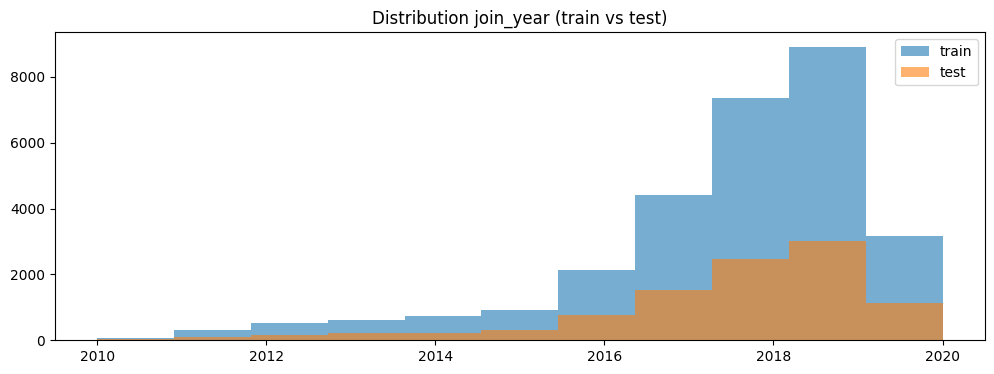

In [23]:
fig = plt.figure(figsize=(12,4))
plt.hist(train_c["join_year"].dropna(), bins=11, alpha=0.6, label="train")
plt.hist(test_c["join_year"].dropna(),  bins=11, alpha=0.6, label="test")
plt.title("Distribution join_year (train vs test)")
plt.legend()
plt.show()




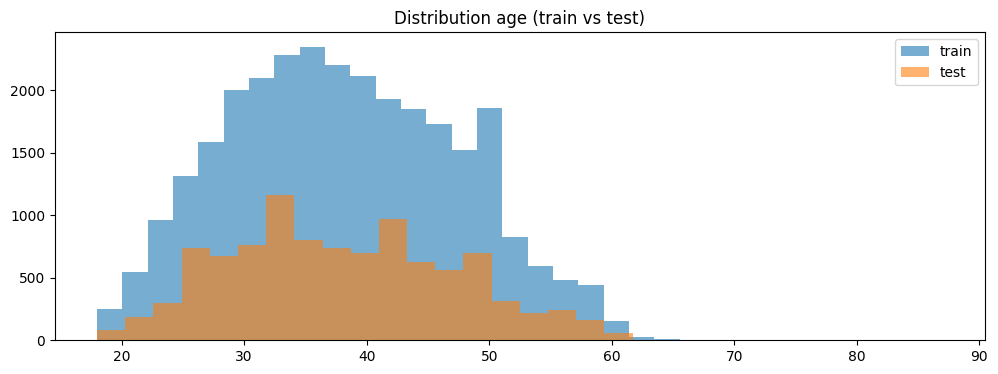

In [24]:
fig = plt.figure(figsize=(12,4))
plt.hist(train_c["age"].dropna(), bins=30, alpha=0.6, label="train")
plt.hist(test_c["age"].dropna(),  bins=30, alpha=0.6, label="test")
plt.title("Distribution age (train vs test)")
plt.legend()
plt.show()

In [25]:
for col in ["sex","marital_status","occupation_category_code","branch_code"]:
    print(f" {col}")
    display(pd.DataFrame({
        "train_count": train_c[col].value_counts(),
        "test_count":  test_c[col].value_counts()
    }).fillna(0).astype(int))




 sex


,train_count,test_count
sex,,
m,20329,6845
f,8803,3155


 marital_status


,train_count,test_count
marital_status,,
m,22913,7878
s,3267,1116
u,2474,843
w,301,105
d,135,51
r,34,5
p,7,1
f,1,1


 occupation_category_code


,train_count,test_count
occupation_category_code,,
t4ms,18619,6383
90qi,5552,1927
56si,3655,1262
l44t,628,208
jd7x,576,191
ahh5,102,29


 branch_code


,train_count,test_count
branch_code,,
1x1h,1303,435
30h5,3151,1114
49bm,621,196
748l,8136,2783
94kc,3658,1191
9f9t,429,146
boas,347,130
e5sw,3185,1069
eu3l,9,4


In [26]:
# occupation_code : on regarde top et la queue
occ_counts = train_c["occupation_code"].value_counts()
occ_counts.head(10)

occupation_code
2a7i    7089
0kid    3969
sst3    2711
uj5t    2079
0ojm    1565
bpsa    1091
qzyx     856
31jw     683
0b60     566
bp09     525
Name: count, dtype: int64

In [27]:
occ_counts.tail(10)

occupation_code
1an5    1
hsve    1
6sky    1
p2k2    1
w3zv    1
zhc2    1
flxh    1
uydz    1
yjxm    1
59qm    1
Name: count, dtype: int64

In [28]:
train_c["occupation_code"].nunique()

233

In [29]:
product_popularity_train = train_c[PRODUCT_COLS].mean().sort_values()
counts_train = train_c[PRODUCT_COLS].sum().astype(int).sort_values()

product_stats = pd.DataFrame({
    "count_train": counts_train,
    "freq_train": product_popularity_train 
})



In [30]:
product_stats.head(10)

,count_train,freq_train
GYSR,4,0.000137
P5DA,40,0.001373
FM3X,110,0.003776
8NN1,157,0.005389
JWFN,311,0.010676
7POT,316,0.010847
BSTQ,324,0.011122
66FJ,339,0.011637
LJR9,354,0.012152
SOP4,431,0.014795


In [31]:
product_stats.tail(10)

,count_train,freq_train
N2MW,838,0.028766
GHYX,902,0.030963
ECY3,1102,0.037828
J9JW,1418,0.048675
JZ9D,1425,0.048915
RIBP,1780,0.061101
PYUQ,2173,0.074592
QBOL,6833,0.234553
K6QO,21629,0.742448
RVSZ,25328,0.869422


In [32]:
rare_1pct = product_stats[product_stats["freq_train"] < 0.01]
common_50pct = product_stats[product_stats["freq_train"] > 0.50]



In [33]:
rare_1pct

,count_train,freq_train
GYSR,4,0.000137
P5DA,40,0.001373
FM3X,110,0.003776
8NN1,157,0.005389


In [34]:
common_50pct

,count_train,freq_train
K6QO,21629,0.742448
RVSZ,25328,0.869422


In [35]:
import plotly.express as px

# On s'assure que tout est bien trié et nommé pour l'affichage
plot_df = product_stats.reset_index().rename(columns={"index": "Produit"})

fig = px.bar(
    plot_df,
    x="Produit",
    y="freq_train",
    
    hover_data={"count_train": True, "freq_train": ":.2%"}, 
    title="Popularité des produits (Train) - fréquences et volumes",
    labels={"freq_train": "Fréquence (%)", "count_train": "Nombre de clients"}
)

fig.update_layout(xaxis_tickangle=-90)
fig.show()


- Certains produits sont extrêmement rares : une association (ou P(B|A)) élevée sur ces produits peut être statistiquement instable si le support est faible.  
- Deux produits sont massivement présents : ils vont dominer les co-occurrences brutes, donc on devra toujours regarder support et lift/conditionnel (pas seulement P(A,B)).  
- La distribution basket_size montre que la majorité des clients train ont 2 produits, et la majorité test a 1 produit : notre baseline doit exceller sur le cas “un seul produit observé”.


# EDA bivariée (qui explique quoi)

In [36]:
train_c["basket_size"] = train_c[PRODUCT_COLS].sum(axis=1)

def group_stats(df, group_col, target_col="basket_size"):
    g = df.groupby(group_col)[target_col].agg(["count","mean","std","median"])
    return g.sort_values("mean", ascending=False)

group_stats(train_c, "sex")

,count,mean,std,median
sex,,,,
m,20329,2.279797,0.617712,2.0
f,8803,2.272748,0.566437,2.0


In [37]:
group_stats(train_c, "marital_status") 

,count,mean,std,median
marital_status,,,,
f,1,4.000000,NaN,4.0
p,7,3.571429,1.812654,3.0
u,2474,2.450283,0.787690,2.0
r,34,2.382353,0.696950,2.0
d,135,2.281481,0.568473,2.0
w,301,2.279070,0.518196,2.0
m,22913,2.263038,0.584426,2.0
s,3267,2.244873,0.543317,2.0


In [38]:
group_stats(train_c, "occupation_category_code")


,count,mean,std,median
occupation_category_code,,,,
l44t,628,2.383758,0.680691,2.0
ahh5,102,2.362745,0.576593,2.0
90qi,5552,2.326189,0.643450,2.0
jd7x,576,2.291667,0.733070,2.0
t4ms,18619,2.284494,0.605594,2.0
56si,3655,2.146375,0.449012,2.0


In [39]:
corr_age  = train_c["age"].corr(train_c["basket_size"], method="spearman")
corr_join = train_c["join_year"].corr(train_c["basket_size"], method="spearman")



In [40]:
corr_age

np.float64(0.13278816392933276)

In [41]:
corr_join

np.float64(0.03141057429182692)

## Lecture “profil ↔ basket_size”

Ces analyses servent à comprendre qui est “multi-produit” et qui est “mono-produit”.  
Même si le moteur repose surtout sur les co-occurrences produits, les variables profil peuvent aider à départager des produits candidats (rerank), surtout quand le panier observé est très petit.


In [44]:
from scipy.stats import chi2_contingency
import math

def cramers_v(tab: pd.DataFrame):
    chi2, p, dof, exp = chi2_contingency(tab, correction=False)
    n = tab.to_numpy().sum()
    r, k = tab.shape
    phi2 = chi2 / n
    return math.sqrt(phi2 / max(1e-12, min(k-1, r-1))), p

def top_cramers_for_feature(df, feature, products, min_pos=50):
    rows = []
    for prod in products:
       
        positive_count = int(df[prod].sum())
        
        if positive_count < min_pos:
            continue
            
        tab = pd.crosstab(df[feature], df[prod])
        if tab.shape[0] < 2 or tab.shape[1] < 2:
            continue
            
        v, p = cramers_v(tab)
        
        rows.append({
            "product": prod, 
            "positive_count": positive_count, 
            "cramers_v": v, 
            "p_value": p
        })
        
    return pd.DataFrame(rows).sort_values("cramers_v", ascending=False)



In [45]:

top_occ_cat = top_cramers_for_feature(train_c, "occupation_category_code", PRODUCT_COLS, min_pos=50)
top_branch  = top_cramers_for_feature(train_c, "branch_code", PRODUCT_COLS, min_pos=50)

In [46]:
top_occ_cat.head(10)

,product,positive_count,cramers_v,p_value
12,K6QO,21629,0.167999,1.808839e-175
5,RVSZ,25328,0.140821,1.326809e-122
13,QBOL,6833,0.120771,1.265485e-89
8,N2MW,838,0.106570,2.306164e-69
0,RIBP,1780,0.096923,4.561403e-57
9,AHXO,539,0.092914,2.624975e-52
6,PYUQ,2173,0.081014,2.161553e-39
14,JWFN,311,0.061763,2.364103e-22
16,J9JW,1418,0.060982,9.197979e-22
15,JZ9D,1425,0.060643,1.650404e-21


In [47]:
top_branch.head(10)

,product,positive_count,cramers_v,p_value
9,AHXO,539,0.838663,0.000000e+00
8,N2MW,838,0.831423,0.000000e+00
5,RVSZ,25328,0.375627,0.000000e+00
12,K6QO,21629,0.346799,0.000000e+00
18,ECY3,1102,0.318036,0.000000e+00
0,RIBP,1780,0.243160,0.000000e+00
13,QBOL,6833,0.211937,7.907974e-271
16,J9JW,1418,0.207903,3.251534e-260
15,JZ9D,1425,0.207803,5.901623e-260
6,PYUQ,2173,0.195273,2.501002e-228


In [48]:


# 2. Filtrer pour voir seulement les relations statistiquement "significatives"
# Par exemple : Cramér's V > 0.05 (lien au moins faible) ET p-value < 0.01 (très significatif)
seuil_cramer = 0.05

signif_occ = top_occ_cat[
    (top_occ_cat["cramers_v"] >= seuil_cramer) & 
    (top_occ_cat["p_value"] < 0.01)
]

print(f"\n=== Relations significatives retenues (V >= {seuil_cramer}) ===")
display(signif_occ)


=== Relations significatives retenues (V >= 0.05) ===


,product,positive_count,cramers_v,p_value
12,K6QO,21629,0.167999,1.808839e-175
5,RVSZ,25328,0.140821,1.326809e-122
13,QBOL,6833,0.120771,1.265485e-89
8,N2MW,838,0.106570,2.306164e-69
0,RIBP,1780,0.096923,4.561403e-57
9,AHXO,539,0.092914,2.624975e-52
6,PYUQ,2173,0.081014,2.161553e-39
14,JWFN,311,0.061763,2.364103e-22
16,J9JW,1418,0.060982,9.197979e-22
15,JZ9D,1425,0.060643,1.650404e-21




- Un Cramér’s V élevé identifie des variables potentiellement utiles pour le rerank (ex. branch_code peut “conditionner” la probabilité de certains produits).  
- On garde ces signaux, mais on évite de sur-interpréter : un V élevé peut aussi refléter une structure d’offre locale fragile si la distribution des branches change en production.  
- Plus tard, on vérifiera la stabilité du signal via drift train/test et performance par segment.


In [49]:
def std_diff(df, prod, col):
    pos = df[df[prod] == 1][col]
    neg = df[df[prod] == 0][col]
    return (pos.mean() - neg.mean()) / df[col].std()

rows=[]
for prod in PRODUCT_COLS:
    if int(train_c[prod].sum()) < 50:
        continue
    rows.append({
        "product": prod,
        "positives": int(train_c[prod].sum()),
        "age_std_diff": std_diff(train_c, prod, "age"),
        "join_year_std_diff": std_diff(train_c, prod, "join_year"),
    })



In [50]:
effects = pd.DataFrame(rows).sort_values("join_year_std_diff", ascending=False)
effects.head(10)


,product,positives,age_std_diff,join_year_std_diff
12,K6QO,21629,-0.162287,0.777850
5,RVSZ,25328,-0.197930,0.705622
18,ECY3,1102,0.182467,0.421139
15,JZ9D,1425,-0.054988,0.398707
16,J9JW,1418,-0.059219,0.395942
17,GHYX,902,0.033210,0.393743
9,AHXO,539,0.428940,0.266699
14,JWFN,311,0.043807,-0.029101
8,N2MW,838,0.383548,-0.029557
13,QBOL,6833,0.507119,-0.066275


In [51]:
effects.tail(10)

,product,positives,age_std_diff,join_year_std_diff
13,QBOL,6833,0.507119,-0.066275
10,BSTQ,324,0.003187,-0.349143
6,PYUQ,2173,0.010985,-1.027774
11,FM3X,110,-0.002226,-1.116120
3,66FJ,339,0.138234,-1.373366
4,SOP4,431,-0.171658,-1.452962
0,RIBP,1780,0.156829,-1.768437
7,LJR9,354,-0.143952,-2.308842
1,8NN1,157,0.043779,-2.388267
2,7POT,316,0.007977,-2.605893


# Produit ↔ produit (le vrai signal) : co-occurrence, support, lift, pivot

- Support(A) : nombre de clients possédant A.  
- Support(A,B) : nombre de clients possédant A et B.  
- Co-occurrence P(A,B) : support(A,B) / N.  
- Probabilité conditionnelle P(B|A) : support(A,B) / support(A).  
- Lift(A,B) : P(A,B) / (P(A)P(B)). Lift>1 indique une association positive au-delà du hasard.  
- Produits “pivot” : produits très connectés (fortes associations avec beaucoup d’autres) ; utiles pour comprendre la structure du panier et construire une baseline.


In [52]:
X = train_c[PRODUCT_COLS].astype(int).values
N = X.shape[0]

co_counts = X.T @ X  
co_prob = co_counts / N

co_counts_df = pd.DataFrame(co_counts, index=PRODUCT_COLS, columns=PRODUCT_COLS)
co_prob_df   = pd.DataFrame(co_prob,   index=PRODUCT_COLS, columns=PRODUCT_COLS)

co_counts_df.iloc[:5,:5]


,P5DA,RIBP,8NN1,7POT,66FJ
P5DA,40,10,1,0,1
RIBP,10,1780,53,135,51
8NN1,1,53,157,30,3
7POT,0,135,30,316,7
66FJ,1,51,3,7,339


In [53]:
co_prob_df.iloc[:5,:5]

,P5DA,RIBP,8NN1,7POT,66FJ
P5DA,0.001373,0.000343,0.000034,0.000000,0.000034
RIBP,0.000343,0.061101,0.001819,0.004634,0.001751
8NN1,0.000034,0.001819,0.005389,0.001030,0.000103
7POT,0.000000,0.004634,0.001030,0.010847,0.000240
66FJ,0.000034,0.001751,0.000103,0.000240,0.011637


In [54]:
co_counts_df

,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
P5DA,40,10,1,0,1,0,1,16,4,1,...,2,2,0,3,7,0,2,2,1,3
RIBP,10,1780,53,135,51,0,48,1041,200,150,...,9,21,5,398,482,6,20,20,15,92
8NN1,1,53,157,30,3,0,5,62,15,15,...,1,3,2,27,26,0,3,3,2,8
7POT,0,135,30,316,7,0,5,67,50,55,...,0,3,1,23,83,1,4,4,5,3
66FJ,1,51,3,7,339,1,9,214,30,14,...,2,2,0,81,75,1,2,2,4,18
GYSR,0,0,0,0,1,4,0,2,1,0,...,0,0,0,1,1,0,0,0,0,0
SOP4,1,48,5,5,9,0,431,280,41,29,...,0,1,1,88,88,1,6,6,2,25
RVSZ,16,1041,62,67,214,2,280,25328,1067,78,...,45,103,25,21629,5177,311,365,363,575,977
PYUQ,4,200,15,50,30,1,41,1067,2173,42,...,12,191,101,433,1010,11,197,196,58,34
LJR9,1,150,15,55,14,0,29,78,42,354,...,3,5,8,33,94,2,15,14,5,5


In [55]:
co_prob_df

,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
P5DA,0.001373,0.000343,0.000034,0.000000,0.000034,0.000000,0.000034,0.000549,0.000137,0.000034,...,0.000069,0.000069,0.000000,0.000103,0.000240,0.000000,0.000069,0.000069,0.000034,0.000103
RIBP,0.000343,0.061101,0.001819,0.004634,0.001751,0.000000,0.001648,0.035734,0.006865,0.005149,...,0.000309,0.000721,0.000172,0.013662,0.016545,0.000206,0.000687,0.000687,0.000515,0.003158
8NN1,0.000034,0.001819,0.005389,0.001030,0.000103,0.000000,0.000172,0.002128,0.000515,0.000515,...,0.000034,0.000103,0.000069,0.000927,0.000892,0.000000,0.000103,0.000103,0.000069,0.000275
7POT,0.000000,0.004634,0.001030,0.010847,0.000240,0.000000,0.000172,0.002300,0.001716,0.001888,...,0.000000,0.000103,0.000034,0.000790,0.002849,0.000034,0.000137,0.000137,0.000172,0.000103
66FJ,0.000034,0.001751,0.000103,0.000240,0.011637,0.000034,0.000309,0.007346,0.001030,0.000481,...,0.000069,0.000069,0.000000,0.002780,0.002574,0.000034,0.000069,0.000069,0.000137,0.000618
GYSR,0.000000,0.000000,0.000000,0.000000,0.000034,0.000137,0.000000,0.000069,0.000034,0.000000,...,0.000000,0.000000,0.000000,0.000034,0.000034,0.000000,0.000000,0.000000,0.000000,0.000000
SOP4,0.000034,0.001648,0.000172,0.000172,0.000309,0.000000,0.014795,0.009611,0.001407,0.000995,...,0.000000,0.000034,0.000034,0.003021,0.003021,0.000034,0.000206,0.000206,0.000069,0.000858
RVSZ,0.000549,0.035734,0.002128,0.002300,0.007346,0.000069,0.009611,0.869422,0.036626,0.002677,...,0.001545,0.003536,0.000858,0.742448,0.177708,0.010676,0.012529,0.012461,0.019738,0.033537
PYUQ,0.000137,0.006865,0.000515,0.001716,0.001030,0.000034,0.001407,0.036626,0.074592,0.001442,...,0.000412,0.006556,0.003467,0.014863,0.034670,0.000378,0.006762,0.006728,0.001991,0.001167
LJR9,0.000034,0.005149,0.000515,0.001888,0.000481,0.000000,0.000995,0.002677,0.001442,0.012152,...,0.000103,0.000172,0.000275,0.001133,0.003227,0.000069,0.000515,0.000481,0.000172,0.000172


In [56]:
prev_train_aligned = train_c[PRODUCT_COLS].mean()   # index=PRODUCT_COLS, ordre intact
p = prev_train_aligned.values

p_outer = np.outer(p, p)
lift = np.divide(co_prob, p_outer, out=np.zeros_like(co_prob), where=(p_outer > 0))

np.fill_diagonal(lift, 0.0)
lift_df = pd.DataFrame(lift, index=PRODUCT_COLS, columns=PRODUCT_COLS)

lift_df


,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
P5DA,0.000000,4.091573,4.638854,0.000000,2.148378,0.000000,1.689791,0.460076,1.340635,2.057345,...,2.702412,4.495679,0.000000,0.101017,0.746100,0.000000,1.022175,1.027221,0.807428,1.982668
RIBP,4.091573,0.000000,5.524927,6.991929,2.462186,0.000000,1.822696,0.672667,1.506332,6.934870,...,0.273278,1.060778,0.743922,0.301160,1.154479,0.315748,0.229702,0.230836,0.272167,1.366333
8NN1,4.638854,5.524927,0.000000,17.615899,1.642072,0.000000,2.152600,0.454215,1.280862,7.862464,...,0.344256,1.718094,3.373712,0.231632,0.706045,0.000000,0.390640,0.392569,0.411428,1.347036
7POT,0.000000,6.991929,17.615899,0.000000,1.903626,0.000000,1.069488,0.243869,2.121258,14.323285,...,0.000000,0.853610,0.838090,0.098034,1.119824,0.296430,0.258779,0.260056,0.511030,0.250971
66FJ,2.148378,2.462186,1.642072,1.903626,0.000000,21.483776,1.794469,0.726078,1.186403,3.398563,...,0.318869,0.530464,0.000000,0.321825,0.943236,0.276319,0.120611,0.121206,0.381087,1.403659
GYSR,0.000000,0.000000,0.000000,0.000000,21.483776,0.000000,0.000000,0.575095,3.351588,0.000000,...,0.000000,0.000000,0.000000,0.336724,1.065857,0.000000,0.000000,0.000000,0.000000,0.000000
SOP4,1.689791,1.822696,2.152600,1.069488,1.794469,0.000000,0.000000,0.747223,1.275314,5.537169,...,0.000000,0.208616,0.614470,0.275004,0.870491,0.217336,0.284596,0.286001,0.149871,1.533386
RVSZ,0.460076,0.672667,0.454215,0.243869,0.726078,0.575095,0.747223,0.000000,0.564773,0.253432,...,0.096027,0.365647,0.261407,1.150190,0.871437,1.150190,0.294610,0.294442,0.733214,1.019723
PYUQ,1.340635,1.506332,1.280862,2.121258,1.186403,3.351588,1.275314,0.564773,0.000000,1.590584,...,0.298472,7.903126,12.309467,0.268387,1.981621,0.474180,1.853369,1.853064,0.862049,0.413626
LJR9,2.057345,6.934870,7.862464,14.323285,3.398563,0.000000,5.537169,0.253432,1.590584,0.000000,...,0.458036,1.269966,5.985003,0.125558,1.132097,0.529220,0.866250,0.812492,0.456174,0.373384


In [57]:
MIN_SUPPORT = 50

# 1) Distribution des supports de paires (hors diagonale)
n_prod = len(PRODUCT_COLS)
off = co_counts[np.triu_indices(n_prod, k=1)]
off_nz = off[off > 0]

q50 = int(np.quantile(off_nz, 0.50))
q75 = int(np.quantile(off_nz, 0.75))
q90 = int(np.quantile(off_nz, 0.90))

# 2) Seuil data-driven (à ajuster si trop strict / trop laxiste)
MIN_SUPPORT = max(20, q75)

# 3) Filtre "support attendu sous indépendance" pour éviter les faux lifts sur produits rares
MIN_EXPECTED = 5.0  

print({"q50": q50, "q75": q75, "q90": q90, "MIN_SUPPORT": MIN_SUPPORT, "MIN_EXPECTED": MIN_EXPECTED})


{'q50': 15, 'q75': 82, 'q90': 364, 'MIN_SUPPORT': 82, 'MIN_EXPECTED': 5.0}


In [58]:

pairs = []
for i, a in enumerate(PRODUCT_COLS):
    for j, b in enumerate(PRODUCT_COLS):
        if j <= i:
            continue

        support_ab = int(co_counts[i, j])
        if support_ab < MIN_SUPPORT:
            continue

        # attendu sous indépendance : N * P(A) * P(B)
        expected_ab = float(N * p[i] * p[j])
        if expected_ab < MIN_EXPECTED:
            continue

        pairs.append({
            "A": a, "B": b,
            "support": support_ab,
            "expected": expected_ab,
            "prevA": float(p[i]), "prevB": float(p[j]),
            "lift": float(lift[i, j]),
            "pB_given_A": float(co_counts[i, j] / max(1, co_counts[i, i])),
            "pA_given_B": float(co_counts[i, j] / max(1, co_counts[j, j])),
        })

pairs_df = pd.DataFrame(pairs).sort_values(["lift", "support"], ascending=False)




In [59]:
pairs_df.head(20)

,A,B,support,expected,prevA,prevB,lift,pB_given_A,pA_given_B
29,N2MW,AHXO,482,15.504668,0.028766,0.018502,31.087411,0.575179,0.894249
45,JZ9D,J9JW,1418,69.361870,0.048915,0.048675,20.443509,0.995088,1.000000
23,PYUQ,FM3X,101,8.205067,0.074592,0.003776,12.309467,0.046480,0.918182
34,BSTQ,J9JW,168,15.770699,0.011122,0.048675,10.652667,0.518519,0.118477
33,BSTQ,JZ9D,168,15.848551,0.011122,0.048915,10.600338,0.518519,0.117895
22,PYUQ,BSTQ,191,24.167651,0.074592,0.011122,7.903126,0.087897,0.589506
0,RIBP,7POT,135,19.307977,0.061101,0.010847,6.991929,0.075843,0.427215
3,RIBP,LJR9,150,21.629823,0.061101,0.012152,6.934870,0.084270,0.423729
43,QBOL,GHYX,465,211.566868,0.234553,0.030963,2.197887,0.068052,0.515521
25,PYUQ,QBOL,1010,509.683818,0.074592,0.234553,1.981621,0.464795,0.147812


In [60]:
mask = (co_counts >= MIN_SUPPORT) & (lift > 1.0)
pivot_strength = np.where(mask, lift, 0.0).sum(axis=1)

pivot_df = pd.DataFrame({
    "product": PRODUCT_COLS,
    "pivot_strength": pivot_strength,
    "prevalence": prev_train_aligned.values,
    "support": np.diag(co_counts).astype(int)
}).sort_values("pivot_strength", ascending=False)

pivot_df.head(10)


,product,pivot_strength,prevalence,support
12,BSTQ,100.003314,0.011122,324
13,FM3X,81.788143,0.003776,110
18,J9JW,34.061699,0.048675,1418
17,JZ9D,34.019170,0.048915,1425
11,AHXO,31.087411,0.018502,539
10,N2MW,31.087411,0.028766,838
8,PYUQ,27.406979,0.074592,2173
1,RIBP,17.953941,0.061101,1780
15,QBOL,11.188829,0.234553,6833
3,7POT,8.111753,0.010847,316



Un lift élevé peut être trompeur si le support est faible (ex. 0.98 sur 40 cas).  
Donc, toute interprétation “forte association” exige : lift élevé ET support suffisant.  
C’est aussi la règle pour une baseline robuste : les signaux rares ne doivent pas dominer.


# Section E — Baseline reco explicable (robuste) : P(B|A) + pondération support

In [61]:
support_A = np.diag(co_counts).astype(float)  # support(A)
cond = np.divide(co_counts, support_A.reshape(-1,1), out=np.zeros_like(co_prob), where=(support_A.reshape(-1,1) > 0))

cond_df = pd.DataFrame(cond, index=PRODUCT_COLS, columns=PRODUCT_COLS)
cond_df


,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
P5DA,1.000000,0.250000,0.025000,0.000000,0.025000,0.000000,0.025000,0.400000,0.100000,0.025000,...,0.050000,0.050000,0.000000,0.075000,0.175000,0.000000,0.050000,0.050000,0.025000,0.075000
RIBP,0.005618,1.000000,0.029775,0.075843,0.028652,0.000000,0.026966,0.584831,0.112360,0.084270,...,0.005056,0.011798,0.002809,0.223596,0.270787,0.003371,0.011236,0.011236,0.008427,0.051685
8NN1,0.006369,0.337580,1.000000,0.191083,0.019108,0.000000,0.031847,0.394904,0.095541,0.095541,...,0.006369,0.019108,0.012739,0.171975,0.165605,0.000000,0.019108,0.019108,0.012739,0.050955
7POT,0.000000,0.427215,0.094937,1.000000,0.022152,0.000000,0.015823,0.212025,0.158228,0.174051,...,0.000000,0.009494,0.003165,0.072785,0.262658,0.003165,0.012658,0.012658,0.015823,0.009494
66FJ,0.002950,0.150442,0.008850,0.020649,1.000000,0.002950,0.026549,0.631268,0.088496,0.041298,...,0.005900,0.005900,0.000000,0.238938,0.221239,0.002950,0.005900,0.005900,0.011799,0.053097
GYSR,0.000000,0.000000,0.000000,0.000000,0.250000,1.000000,0.000000,0.500000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
SOP4,0.002320,0.111369,0.011601,0.011601,0.020882,0.000000,1.000000,0.649652,0.095128,0.067285,...,0.000000,0.002320,0.002320,0.204176,0.204176,0.002320,0.013921,0.013921,0.004640,0.058005
RVSZ,0.000632,0.041101,0.002448,0.002645,0.008449,0.000079,0.011055,1.000000,0.042127,0.003080,...,0.001777,0.004067,0.000987,0.853956,0.204398,0.012279,0.014411,0.014332,0.022702,0.038574
PYUQ,0.001841,0.092039,0.006903,0.023010,0.013806,0.000460,0.018868,0.491026,1.000000,0.019328,...,0.005522,0.087897,0.046480,0.199264,0.464795,0.005062,0.090658,0.090198,0.026691,0.015647
LJR9,0.002825,0.423729,0.042373,0.155367,0.039548,0.000000,0.081921,0.220339,0.118644,1.000000,...,0.008475,0.014124,0.022599,0.093220,0.265537,0.005650,0.042373,0.039548,0.014124,0.014124


In [62]:
support_A_series = pd.Series(support_A.astype(int), index=PRODUCT_COLS).sort_values()
support_A_series.head(10)


GYSR      4
P5DA     40
FM3X    110
8NN1    157
JWFN    311
7POT    316
BSTQ    324
66FJ    339
LJR9    354
SOP4    431
dtype: int64

In [63]:
support_A_series.tail(10)

N2MW      838
GHYX      902
ECY3     1102
J9JW     1418
JZ9D     1425
RIBP     1780
PYUQ     2173
QBOL     6833
K6QO    21629
RVSZ    25328
dtype: int64

## Baseline client : moyenne des P(B|A) des produits possédés

Pour un client, on observe un ensemble de produits A .
La baseline score chaque produit candidat B par la moyenne des P(B|A) sur les produits A observés, puis masque les produits déjà détenus.  
Limite : si un produit A est rare, ses conditionnelles sont moins fiables. Donc on pondère par support(A).


In [64]:
product_to_idx = {p: i for i, p in enumerate(PRODUCT_COLS)}
support_weights = support_A.copy()

def score_conditional_weighted_for_client(row_products: pd.Series) -> pd.Series:
    owned_idx = [product_to_idx[p] for p in PRODUCT_COLS if row_products[p] == 1]
    if not owned_idx:
        scores = np.zeros(len(PRODUCT_COLS))
    else:
        w = support_weights[owned_idx].astype(float)
        w = w / w.sum() if w.sum() > 0 else np.ones_like(w) / len(w)
        #scores = (cond[:, owned_idx] * w.reshape(1, -1)).sum(axis=1)
        scores = (cond[owned_idx, :] * w.reshape(-1, 1)).sum(axis=0)
        scores[owned_idx] = -np.inf


    # Masque métier : ne pas recommander ce qui est déjà à 1
    for p in PRODUCT_COLS:
        if row_products[p] == 1:
            scores[product_to_idx[p]] = -np.inf

    return pd.Series(scores, index=PRODUCT_COLS)

example_scores = score_conditional_weighted_for_client(train_c.loc[0, PRODUCT_COLS])




On construit une **baseline de recommandation** (simple et explicable) pour notre problème “basket completion”.

* Entrée : un client avec certains produits déjà à 1 (dans ton exemple : `RVSZ=1` et `K6QO=1`).
* Sortie : un score pour chaque produit **candidat** (les produits à 0), qui représente **à quel point ce produit est probable** compte tenu des produits observés.

Cette baseline ne fait pas de “ML”, elle exploite uniquement le signal produit-produit appris dans le train.


### `product_to_idx = {p: i ...}`

On crée un dictionnaire :

* clé = nom du produit (ex. `"RVSZ"`)
* valeur = son index dans la matrice (ex. 7)

But : accéder rapidement aux colonnes/indices dans les matrices numpy (`cond`).

### `support_A`

C’est `diag(co_counts)` :

* `support_A[A]` = **nombre de clients dans le train qui possèdent le produit A**.
* Un produit fréquent → support grand → estimations plus fiables.
* Un produit rare → support petit → estimations plus bruitées.

### `cond`

C’est la matrice des probabilités conditionnelles :

* `cond[B, A] = P(B=1 | A=1)` estimé sur le train.

Interprétation : “parmi les clients qui ont A, quelle proportion a aussi B ?”

---



On veut que les produits **très fréquents** (support élevé) aient **plus de poids**, parce que leurs statistiques `P(B|A)` sont plus stables.

Donc :

* si `RVSZ` est très fréquent et `K6QO` aussi, ils pèsent beaucoup et de façon comparable,
* si on avait un produit rare dans le panier, il pèserait moins (bonne idée pour éviter les signaux “fantômes”).

### Étape C — score final = moyenne pondérée des conditionnelles

```python
scores = (cond[:, owned_idx] * w.reshape(1, -1)).sum(axis=1)
```

Ça veut dire :

* pour chaque produit candidat `B`,
* on prend `P(B|RVSZ)` et `P(B|K6QO)`,
* on les combine avec les poids,
* on obtient un score dans [0,1].

Donc ces scores sont interprétables comme :

> “probabilité moyenne (pondérée) que B apparaisse chez les clients qui ont les produits du panier observé”.


```python
scores[idx_of_owned] = -inf
```

On force `RVSZ` et `K6QO` à `-inf` pour qu’ils n’apparaissent jamais dans le Top-K (car déjà détenus).
C’est indispensable pour une reco actionnable.

---



le premier client a :

* `RVSZ = 1`
* `K6QO = 1`
* tout le reste à 0

Donc on est dans un cas très réaliste : **panier observé petit**.

### Lecture des scores 

```
JWFN    0.986670
ECY3    0.727738
QBOL    0.638533
GHYX    0.554746
...
RVSZ    -inf
K6QO    -inf
```

Interprétation concrète :

* `JWFN ≈ 0.987` : **parmi les clients qui ont un panier similaire (RVSZ/K6QO), presque tous ont aussi JWFN** (selon l’estimation train). C’est une reco très “forte”.
* `ECY3 ≈ 0.728` : association forte aussi, mais moins extrême.
* `RVSZ` et `K6QO` sont masqués → normal.

### C) Attention critique (très important)

Un score très haut (0.98) peut venir de deux situations :

1. **vrai produit “compagnon”** (bundle naturel, produit quasi systématique)
2. **effet mécanique** : si `RVSZ` est un produit très “central” (pivot), il peut entraîner des conditionnelles élevées vers certains produits.






> Ici nous construisons une baseline de recommandation basée sur les probabilités conditionnelles produit-produit.
> Pour un client, nous identifions les produits déjà détenus (A) puis nous scorons chaque produit candidat (B) par une moyenne pondérée de P(B|A). Les poids sont proportionnels au support(A) afin que les produits fréquents (estimations plus stables) influencent davantage le score que les produits rares.
> Enfin, nous appliquons un masque métier : un produit déjà détenu ne doit jamais être recommandé (score = -inf).
> Les scores obtenus sont dans [0,1] et sont interprétables : plus le score est élevé, plus B est “compatible” avec le panier observé selon les co-occurrences du train.


In [65]:
train_c.loc[0, PRODUCT_COLS]


P5DA    0
RIBP    0
8NN1    0
7POT    0
66FJ    0
GYSR    0
SOP4    0
RVSZ    1
PYUQ    0
LJR9    0
N2MW    0
AHXO    0
BSTQ    0
FM3X    0
K6QO    1
QBOL    0
JWFN    0
JZ9D    0
J9JW    0
GHYX    0
ECY3    0
Name: 0, dtype: object

In [66]:
example_scores.sort_values(ascending=False)


QBOL    0.182869
ECY3    0.033520
PYUQ    0.031944
RIBP    0.030645
GHYX    0.021041
JWFN    0.013054
JZ9D    0.012905
J9JW    0.012842
SOP4    0.007837
66FJ    0.006282
N2MW    0.005707
BSTQ    0.003471
LJR9    0.002364
7POT    0.001917
8NN1    0.001895
AHXO    0.001427
FM3X    0.000788
P5DA    0.000405
GYSR    0.000064
RVSZ        -inf
K6QO        -inf
dtype: float64


Ces scores sont dans [0,1] car ils représentent une probabilité conditionnelle moyenne.  
Ils sont interprétables : “si on observe les produits du panier, quelle est la probabilité qu’un produit candidat apparaisse aussi ?”.  
C’est une baseline forte car elle correspond exactement au problème dominant (test = panier souvent de taille 1).


In [67]:

row = train_c.loc[0, PRODUCT_COLS]
owned = [p for p in PRODUCT_COLS if row[p] == 1]
candidates = example_scores.replace([-np.inf, np.inf], np.nan).dropna()

print("Produits observés (panier client):", owned)


Produits observés (panier client): ['RVSZ', 'K6QO']


In [68]:

#Fonctions utilitaires : support, attendu, verdict 
product_to_idx = {p: i for i, p in enumerate(PRODUCT_COLS)}

def pair_stats(A: str, B: str):
    i, j = product_to_idx[A], product_to_idx[B]

    supA  = int(co_counts[i, i])
    supB  = int(co_counts[j, j])
    supAB = int(co_counts[min(i, j), max(i, j)]) if i != j else int(co_counts[i, i])

    # support attendu sous indépendance : N * P(A)*P(B)
    expected = float(N * p[i] * p[j]) if i != j else float(supA)

    # probas conditionnelles (dans les deux sens)
    pB_given_A = float(supAB / supA) if supA > 0 else 0.0
    pA_given_B = float(supAB / supB) if supB > 0 else 0.0

    return supA, supB, supAB, expected, pB_given_A, pA_given_B

def verdict_pair(supAB: int, expected: float, min_support: int, min_expected: float):
    # verdict simple et parlant
    if supAB < min_support and expected < min_expected:
        return "fragile (rare + peu observé)"
    if supAB < min_support:
        return "fragile (support faible)"
    if expected < min_expected:
        return "fragile (attendu faible → possible hasard sur produit rare)"
    return "OK (solide)"

def why_pair(supAB: int, expected: float, min_support: int, min_expected: float):
    reasons = []
    if supAB < min_support:
        reasons.append(f"support<{min_support}")
    if expected < min_expected:
        reasons.append(f"attendu<{min_expected:.1f}")
    return ", ".join(reasons) if reasons else "support et attendu suffisants"


In [69]:
TOPK = 10
topk = candidates.sort_values(ascending=False).head(TOPK)

rows = []
for B, score in topk.items():
    for A in owned:
        supA, supB, supAB, expected, pB_given_A, pA_given_B = pair_stats(A, B)

        rows.append({
            "produit_observe_A": A,
            "produit_candidat_B": B,
            "score_baseline": float(score),                     # score final (moyenne pondérée)
            "P(B|A)": pB_given_A,                               # signal direct par produit observé
            "support(A)": supA,
            "support(B)": supB,
            "support(A,B)": supAB,
            "support_attendu_indep": expected,
            "verdict": verdict_pair(supAB, expected, MIN_SUPPORT, MIN_EXPECTED),
            "pourquoi": why_pair(supAB, expected, MIN_SUPPORT, MIN_EXPECTED),
        })

audit_topk = pd.DataFrame(rows).sort_values(
    ["score_baseline", "produit_candidat_B", "P(B|A)"],
    ascending=[False, True, False]
)

audit_topk


,produit_observe_A,produit_candidat_B,score_baseline,P(B|A),support(A),support(B),"support(A,B)",support_attendu_indep,verdict,pourquoi
0,RVSZ,QBOL,0.182869,0.204398,25328,6833,5177,5940.760126,OK (solide),support et attendu suffisants
1,K6QO,QBOL,0.182869,0.157659,21629,6833,3410,5073.148325,OK (solide),support et attendu suffisants
2,RVSZ,ECY3,0.033520,0.038574,25328,1102,977,958.102980,OK (solide),support et attendu suffisants
3,K6QO,ECY3,0.033520,0.027602,21629,1102,597,818.177880,OK (solide),support et attendu suffisants
4,RVSZ,PYUQ,0.031944,0.042127,25328,2173,1067,1889.253879,OK (solide),support et attendu suffisants
5,K6QO,PYUQ,0.031944,0.020019,21629,2173,433,1613.339867,OK (solide),support et attendu suffisants
6,RVSZ,RIBP,0.030645,0.041101,25328,1780,1041,1547.571056,OK (solide),support et attendu suffisants
7,K6QO,RIBP,0.030645,0.018401,21629,1780,398,1321.557737,OK (solide),support et attendu suffisants
8,RVSZ,GHYX,0.021041,0.022702,25328,902,575,784.218591,OK (solide),support et attendu suffisants
9,K6QO,GHYX,0.021041,0.019095,21629,902,413,669.688247,OK (solide),support et attendu suffisants


In [70]:

def aggregate_verdict(group: pd.DataFrame):
    # Si au moins une relation A->B est fragile, on note “prudence”
    if (group["verdict"] != "OK (solide)").any():
        return "prudence"
    return "OK"

summary_rows = []
for B, grp in audit_topk.groupby("produit_candidat_B"):
    summary_rows.append({
        "produit_candidat_B": B,
        "score_baseline": float(grp["score_baseline"].iloc[0]),
        "min_support_AB": int(grp["support(A,B)"].min()),
        "min_expected": float(grp["support_attendu_indep"].min()),
        "nb_liens_fragiles": int((grp["verdict"] != "OK (solide)").sum()),
        "verdict_global": aggregate_verdict(grp),
        "note": "solide si support(A,B) et attendu suffisants pour tous les A observés"
    })

audit_summary = pd.DataFrame(summary_rows).sort_values("score_baseline", ascending=False)
audit_summary


,produit_candidat_B,score_baseline,min_support_AB,min_expected,nb_liens_fragiles,verdict_global,note
7,QBOL,0.182869,3410,5073.148325,0,OK,"solide si support(A,B) et attendu suffisants p..."
1,ECY3,0.033520,597,818.177880,0,OK,"solide si support(A,B) et attendu suffisants p..."
6,PYUQ,0.031944,433,1613.339867,0,OK,"solide si support(A,B) et attendu suffisants p..."
8,RIBP,0.030645,398,1321.557737,0,OK,"solide si support(A,B) et attendu suffisants p..."
2,GHYX,0.021041,413,669.688247,0,OK,"solide si support(A,B) et attendu suffisants p..."
4,JWFN,0.013054,302,230.901380,0,OK,"solide si support(A,B) et attendu suffisants p..."
5,JZ9D,0.012905,241,1057.988638,0,OK,"solide si support(A,B) et attendu suffisants p..."
3,J9JW,0.012842,240,1052.791501,0,OK,"solide si support(A,B) et attendu suffisants p..."
9,SOP4,0.007837,88,319.995160,0,OK,"solide si support(A,B) et attendu suffisants p..."
0,66FJ,0.006282,81,251.689929,1,prudence,"solide si support(A,B) et attendu suffisants p..."


In [71]:

audit_summary["est_OK"] = audit_summary["verdict_global"].eq("OK")
audit_summary["est_fragile"] = ~audit_summary["est_OK"]

audit_summary.head(10)


,produit_candidat_B,score_baseline,min_support_AB,min_expected,nb_liens_fragiles,verdict_global,note,est_OK,est_fragile
7,QBOL,0.182869,3410,5073.148325,0,OK,"solide si support(A,B) et attendu suffisants p...",True,False
1,ECY3,0.033520,597,818.177880,0,OK,"solide si support(A,B) et attendu suffisants p...",True,False
6,PYUQ,0.031944,433,1613.339867,0,OK,"solide si support(A,B) et attendu suffisants p...",True,False
8,RIBP,0.030645,398,1321.557737,0,OK,"solide si support(A,B) et attendu suffisants p...",True,False
2,GHYX,0.021041,413,669.688247,0,OK,"solide si support(A,B) et attendu suffisants p...",True,False
4,JWFN,0.013054,302,230.901380,0,OK,"solide si support(A,B) et attendu suffisants p...",True,False
5,JZ9D,0.012905,241,1057.988638,0,OK,"solide si support(A,B) et attendu suffisants p...",True,False
3,J9JW,0.012842,240,1052.791501,0,OK,"solide si support(A,B) et attendu suffisants p...",True,False
9,SOP4,0.007837,88,319.995160,0,OK,"solide si support(A,B) et attendu suffisants p...",True,False
0,66FJ,0.006282,81,251.689929,1,prudence,"solide si support(A,B) et attendu suffisants p...",False,True


In [72]:

A = owned[0] if owned else None
B = audit_summary["produit_candidat_B"].iloc[0]

if A is not None:
    supA, supB, supAB, expected, pB_given_A, pA_given_B = pair_stats(A, B)
    print(f"A: {A}")
    print(f"B: {B}")
    print(f"P(B|A): {pB_given_A}")
    print(f"support(A): {supA}")
    print(f"support(B): {supB}")
    print(f"support(A,B): {supAB}")
    print(f"attendu_indep: {expected}")
    print(f"MIN_SUPPORT: {MIN_SUPPORT}")
    print(f"MIN_EXPECTED: {MIN_EXPECTED}")
    verdict = verdict_pair(supAB, expected, MIN_SUPPORT, MIN_EXPECTED)  
    print(f"Verdict: {verdict}")
else:
    print("Panier vide: aucun produit observé.")


A: RVSZ
B: QBOL
P(B|A): 0.20439829437776375
support(A): 25328
support(B): 6833
support(A,B): 5177
attendu_indep: 5940.760126321571
MIN_SUPPORT: 82
MIN_EXPECTED: 5.0
Verdict: OK (solide)


# evaluation de notre V0

Nous n’avons pas de colonne cible explicite dans le CSV. Pour créer une cible supervisée, nous reproduisons le mécanisme du test : pour chaque client du train, nous choisissons un produit réellement détenu (valeur 1) et nous le masquons (on le passe à 0).
Le produit masqué devient alors la vérité terrain (la “target”) : c’est exactement ce que le modèle doit retrouver à partir du panier observé.

Concrètement, pour chaque client :

1. On part du panier complet `X_full` (vecteur de 21 produits en 0/1).
2. On sélectionne un produit `hide` parmi ceux à 1.
3. On crée un panier observé `X_obs` identique, sauf que `X_obs[hide]=0`.
4. On stocke l’index du produit masqué `y_true = hide` (c’est la réponse attendue).
5. Le modèle produit un score pour chaque produit candidat.
6. On trie les produits par score décroissant (Top-K).
7. On vérifie si `y_true` est bien dans le Top-K (Hit@K) et à quel rang (MRR).

Donc oui : on “retient” explicitement **la position (l’index) du produit masqué** pour savoir si la prédiction est correcte.

---

## Ce qu’on compare exactement : Hit@K et MRR

* Hit@K : “est-ce que le produit masqué est dans les K meilleurs ?”

  * Hit@1 = top-1 accuracy (le modèle met-il le bon produit en premier ?)
  * Hit@5 = utile pour une reco (si l’utilisateur voit 5 suggestions)

* MRR (Mean Reciprocal Rank) : mesure la qualité du rang

  * Si le produit masqué est 1er → contribution = 1.0
  * S’il est 2e → 0.5
  * 5e → 0.2
  * pas dans la liste → 0.0
    Plus MRR est haut, mieux c’est (le bon produit arrive tôt).

---

## Pourquoi on impose “basket_size >= 2” avant masquage

Dans le train, beaucoup de clients ont exactement 2 produits.
Si on masque 1 produit, il reste 1 produit observé : c’est **le cas dominant du test** (test ≈ 1.29 produits en moyenne).
Si un client avait 1 seul produit et qu’on le masque, on obtient un panier vide (0 produit), ce qui est incompatible avec le test (et rend la reco impossible).

---

## Lecture “objet” des variables (pour éviter toute confusion)

* `X_full[i]` : panier complet du client i (train), longueur 21
* `owned = where(X_full[i]==1)` : indices des produits détenus
* `hide` : un indice choisi au hasard dans `owned`
* `X_obs[i]` : panier observé (même que X_full mais avec hide mis à 0)
* `y_true[i] = hide` : la vérité terrain (position du produit masqué)
* `scores[i, j]` : score prédit pour recommander le produit j au client i
* `ranked[i]` : les indices des produits triés par score (Top-K = `ranked[i, :K]`)

---

## Important : ce qu’on évalue vraiment

On n’évalue pas “prédire tous les produits”.
On évalue une tâche précise : **retrouver le produit manquant** (basket completion), exactement comme la soumission Kaggle.



Nous évaluons la baseline en reproduisant la construction du test : pour chaque client du train, nous masquons 1 produit réellement détenu, puis nous demandons au modèle de le retrouver dans le Top-K.
Nous reportons Hit@K (Top-K accuracy), MRR (rang moyen), et une analyse par taille de panier et par produit (produits “faciles” vs “rares”).

## Évaluation avec masquage (pour simuler le test)

Idée : le vrai test est construit en masquant 1 produit détenu. Pour évaluer correctement sur le train :

1) On sélectionne des clients avec au moins 2 produits (sinon on ne peut pas enlever 1 produit en gardant un panier non vide).
2) Pour chaque client, on choisit au hasard un des produits à 1, on le met à 0 : c’est le panier observé.
3) On retient l’index du produit masqué (`y_true`) pour vérifier ensuite si notre ranking le retrouve (Hit@K, MRR).

Ce protocole est “train → pseudo-test”, reproductible (seed), et aligné avec l’objectif Top-K.


In [73]:

rng = np.random.default_rng(42)

X_full = train_c[PRODUCT_COLS].astype(int).values
N, P = X_full.shape

basket_size_full = X_full.sum(axis=1)

# On évalue uniquement sur les clients avec au moins 2 produits,
# pour pouvoir masquer 1 produit tout en gardant >=1 produit observé
eligible = np.where(basket_size_full >= 2)[0]


In [74]:
#Masking : 1 produit masqué par client

X_obs = X_full[eligible].copy()
y_true = np.empty(len(eligible), dtype=int)

for t, i in enumerate(eligible):
    owned = np.where(X_full[i] == 1)[0]
    hide = rng.choice(owned)
    y_true[t] = hide
    X_obs[t, hide] = 0

assert X_obs.shape[0] == y_true.shape[0]
assert (X_obs.sum(axis=1) >= 1).all(), "Masking invalide: certains paniers observés sont vides."


In [75]:
# Cellule — Évaluer la baseline sur un masquage (1 produit caché) + sanity checks
# Hypothèses : on a déjà
# - X_obs : panier observé (après masquage)
# - y_true : index du produit masqué (vérité terrain)
# - cond : matrice conditionnelle construite comme cond[A,B] = P(B|A)
# - support_weights : poids par produit (support(A))
# - PRODUCT_COLS, P

def score_one_forward(X_row_obs: np.ndarray) -> np.ndarray:
    # Score(B) = moyenne_pondérée_{A observés} P(B | A)
    owned_idx = np.where(X_row_obs == 1)[0]
    scores = np.zeros(P, dtype=float)
    if owned_idx.size > 0:
        w = support_weights[owned_idx]
        w = w / w.sum() if w.sum() > 0 else np.ones_like(w) / owned_idx.size
        # cond[owned_idx, :] : lignes = A observés, colonnes = B candidats
        scores = (cond[owned_idx, :] * w.reshape(-1, 1)).sum(axis=0)

    # masque : ne pas recommander déjà détenu
    scores[owned_idx] = -np.inf
    return scores

def score_one_backward(X_row_obs: np.ndarray) -> np.ndarray:
    # Version 'inverse' (agrège P(A | B)) : utile uniquement comme contre-exemple
    owned_idx = np.where(X_row_obs == 1)[0]
    scores = np.zeros(P, dtype=float)
    if owned_idx.size > 0:
        w = support_weights[owned_idx]
        w = w / w.sum() if w.sum() > 0 else np.ones_like(w) / owned_idx.size
        scores = (cond[:, owned_idx] * w.reshape(1, -1)).sum(axis=1)

    scores[owned_idx] = -np.inf
    return scores

# Scoring sur tout le jeu (boucle simple, P=21 donc rapide)
scores_forward = np.vstack([score_one_forward(X_obs[i]) for i in range(X_obs.shape[0])])
scores_backward = np.vstack([score_one_backward(X_obs[i]) for i in range(X_obs.shape[0])])

ranked_forward = np.argsort(-scores_forward, axis=1)   # top en premier
ranked_backward = np.argsort(-scores_backward, axis=1) # top en premier

def hit_at_k(ranked_idx: np.ndarray, y: np.ndarray, k: int) -> float:
    return float(np.mean([y[i] in ranked_idx[i, :k] for i in range(len(y))]))

def mrr(ranked_idx: np.ndarray, y: np.ndarray) -> float:
    rr = []
    for i in range(len(y)):
        pos = np.where(ranked_idx[i] == y[i])[0]
        rr.append(1.0 / (pos[0] + 1) if pos.size else 0.0)
    return float(np.mean(rr))

K_list = [1, 3, 5, 10]

metrics_forward = {f"Hit@{k}": hit_at_k(ranked_forward, y_true, k) for k in K_list}
metrics_forward["MRR"] = mrr(ranked_forward, y_true)

metrics_backward = {f"Hit@{k}": hit_at_k(ranked_backward, y_true, k) for k in K_list}
metrics_backward["MRR"] = mrr(ranked_backward, y_true)

pd.DataFrame([metrics_forward, metrics_backward], index=["forward P(B|A)", "backward P(A|B)"])


,Hit@1,Hit@3,Hit@5,Hit@10,MRR
forward P(B|A),0.820781,0.919470,0.960971,0.986475,0.878021
backward P(A|B),0.349341,0.814259,0.872992,0.932857,0.598914


### Choix de la baseline retenue + contrôle “default recommender”

On compare deux orientations :
- forward : score(B) = moyenne pondérée des P(B|A) pour les produits observés A (ce qu’on veut).
- backward : agrège P(A|B) (utile seulement pour diagnostiquer une inversion d’axes / un effet “hub”).

Nous retenons **forward** comme baseline, puis on vérifie si le top-1 est excessivement dominé par un produit (symptôme d’un recommender “par défaut”).

In [76]:
# Baseline retenue : forward
scores_mat = scores_forward
ranked = ranked_forward
metrics = metrics_forward

pd.Series(metrics)

# Sanity check : distribution du produit prédit en top-1
top1 = ranked[:, 0]
top1_dist = (
    pd.Series(top1).value_counts()
      .rename_axis("product_idx").reset_index(name="count")
)
top1_dist["product"] = top1_dist["product_idx"].map(lambda j: PRODUCT_COLS[int(j)])
top1_dist["share"] = top1_dist["count"] / top1_dist["count"].sum()
top1_dist.head(10)


,product_idx,count,product,share
0,7,13766,RVSZ,0.472539
1,14,11719,K6QO,0.402272
2,15,1811,QBOL,0.062165
3,18,387,J9JW,0.013284
4,17,384,JZ9D,0.013181
5,11,369,AHXO,0.012666
6,8,235,PYUQ,0.008067
7,10,233,N2MW,0.007998
8,1,228,RIBP,0.007826


In [77]:
# Classement décroissant
ranked = np.argsort(-scores_mat, axis=1)

In [78]:
# Métriques

def hit_at_k(ranked_idx: np.ndarray, y: np.ndarray, k: int) -> float:
    return float(np.mean([y[i] in ranked_idx[i, :k] for i in range(len(y))]))

def mrr(ranked_idx: np.ndarray, y: np.ndarray) -> float:
    rr = []
    for i in range(len(y)):
        pos = np.where(ranked_idx[i] == y[i])[0]
        rr.append(1.0 / (pos[0] + 1) if pos.size else 0.0)
    return float(np.mean(rr))

K_list = [1, 3, 5, 10]
metrics = {f"Hit@{k}": hit_at_k(ranked, y_true, k) for k in K_list}
metrics["MRR"] = mrr(ranked, y_true)



In [79]:
# Breakdown par basket_size observé

basket_obs = X_obs.sum(axis=1)

rows = []
for bs in sorted(np.unique(basket_obs)):
    sel = np.where(basket_obs == bs)[0]
    if sel.size < 200:  # seuil lisible (à ajuster)
        continue
    rows.append({
        "basket_size_observe": int(bs),
        "n": int(sel.size),
        "Hit@1": hit_at_k(ranked[sel], y_true[sel], 1),
        "Hit@5": hit_at_k(ranked[sel], y_true[sel], 5),
        "MRR": mrr(ranked[sel], y_true[sel]),
    })

pd.DataFrame(rows).sort_values("basket_size_observe")


,basket_size_observe,n,Hit@1,Hit@5,MRR
0,1,22732,0.845328,0.966787,0.895254
1,2,5169,0.773651,0.949313,0.842414
2,3,916,0.579694,0.894105,0.711618
3,4,215,0.553488,0.925581,0.723608


In [80]:

# Breakdown par produit masqué

rows = []
for j, prod in enumerate(PRODUCT_COLS):
    sel = np.where(y_true == j)[0]
    if sel.size < 100:  # seuil lisible (à ajuster)
        continue
    rows.append({
        "masked_product": prod,
        "n": int(sel.size),
        "prev_train": float(p[j]),
        "Hit@1": hit_at_k(ranked[sel], y_true[sel], 1),
        "Hit@5": hit_at_k(ranked[sel], y_true[sel], 5),
        "MRR": mrr(ranked[sel], y_true[sel]),
    })

pd.DataFrame(rows).sort_values(["Hit@5", "n"], ascending=[False, False])


,masked_product,n,prev_train,Hit@1,Hit@5,MRR
4,RVSZ,11718,0.869422,0.992576,1.000000,0.995946
9,K6QO,9803,0.742448,1.000000,1.000000,1.000000
10,QBOL,2593,0.234553,0.422291,1.000000,0.704538
13,J9JW,545,0.048675,0.700917,1.000000,0.816208
12,JZ9D,523,0.048915,0.734226,0.998088,0.835628
5,PYUQ,882,0.074592,0.080499,0.996599,0.382275
0,RIBP,724,0.061101,0.122928,0.968232,0.359784
8,AHXO,276,0.018502,0.880435,0.898551,0.891435
15,ECY3,414,0.037828,0.000000,0.855072,0.318146
14,GHYX,331,0.030963,0.000000,0.770393,0.197662


# Section F — Drift train/test (sur profils uniquement)

In [81]:
from scipy.stats import ks_2samp, chi2_contingency

def ks_report(train_s, test_s):
    t = train_s.dropna()
    u = test_s.dropna()
    res = ks_2samp(t, u)
    return {"stat": float(res.statistic), "p_value": float(res.pvalue)}

def chi2_train_test(train_s, test_s):
    tr = train_s.astype(str)
    te = test_s.astype(str)
    cats = sorted(set(tr.unique()) | set(te.unique()))
    tr_counts = tr.value_counts().reindex(cats, fill_value=0)
    te_counts = te.value_counts().reindex(cats, fill_value=0)
    table = np.vstack([tr_counts.values, te_counts.values])
    chi2, p, dof, exp = chi2_contingency(table)
    return {"chi2": float(chi2), "p_value": float(p), "n_categories": len(cats)}

drift = []
drift.append({"feature": "age", **ks_report(train_c["age"], test_c["age"])})
drift.append({"feature": "join_year", **ks_report(train_c["join_year"], test_c["join_year"])})
for c in ["sex","marital_status","branch_code","occupation_category_code"]:
    drift.append({"feature": c, **chi2_train_test(train_c[c], test_c[c])})

pd.DataFrame(drift)


,feature,stat,p_value,chi2,n_categories
0,age,0.012037,0.229136,NaN,NaN
1,join_year,0.005801,0.962387,NaN,NaN
2,sex,NaN,0.013028,6.165245,2.0
3,marital_status,NaN,0.647932,5.098601,8.0
4,branch_code,NaN,0.736008,10.352181,15.0
5,occupation_category_code,NaN,0.925366,1.390347,6.0



On analyse le drift sur les variables profil car elles sont comparables entre train et test.  
On n’interprète pas le drift sur les produits entre train et test, car le test est mécaniquement “appauvri” par le masquage d’un produit.


#  Multivarié “panier” : segmentation simple (utile pour analyse d’erreurs plus tard)

In [82]:
X = train_c[PRODUCT_COLS].astype(int).values
df_prod = train_c[PRODUCT_COLS].sum(axis=0).values
n = X.shape[0]

idf = np.log((n + 1) / (df_prod + 1)) + 1
X_tfidf = X * idf.reshape(1, -1)
X_tfidf.shape


(29132, 21)

Analyse en cours pour k de 2 à 12...
k=2 : Inertie=233623, Silhouette=0.607
k=3 : Inertie=201800, Silhouette=0.497
k=4 : Inertie=179286, Silhouette=0.529
k=5 : Inertie=154764, Silhouette=0.579
k=6 : Inertie=139599, Silhouette=0.619
k=7 : Inertie=128590, Silhouette=0.642
k=8 : Inertie=109248, Silhouette=0.697
k=9 : Inertie=96717, Silhouette=0.729
k=10 : Inertie=87075, Silhouette=0.756
k=11 : Inertie=81123, Silhouette=0.762
k=12 : Inertie=73495, Silhouette=0.787


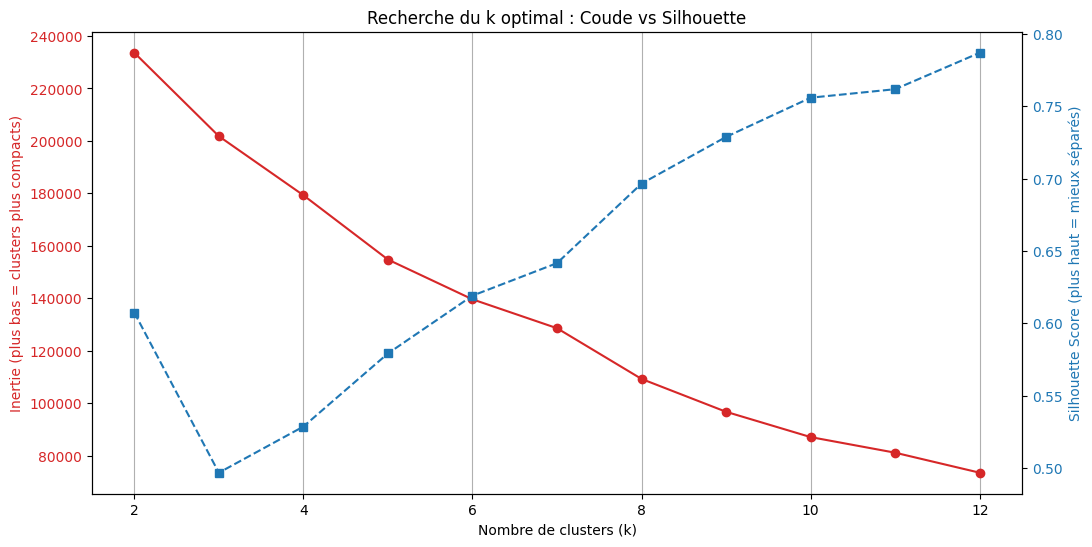

In [83]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def analyze_optimal_k(X, k_min=2, k_max=12):
    inertias = []
    silhouettes = []
    K_range = range(k_min, k_max + 1)
    
    print(f"Analyse en cours pour k de {k_min} à {k_max}...")
    
    for k in K_range:
        # On peut réduire n_init à 10 pour aller plus vite pendant la recherche
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)
        
        inertias.append(km.inertia_)
        
        score = silhouette_score(X, labels, sample_size=5000, random_state=42)
        silhouettes.append(score)
        print(f"k={k} : Inertie={int(km.inertia_)}, Silhouette={score:.3f}")

    # --- Affichage des courbes ---
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Courbe d'Inertie (Méthode du coude)
    color = 'tab:red'
    ax1.set_xlabel('Nombre de clusters (k)')
    ax1.set_ylabel('Inertie (plus bas = clusters plus compacts)', color=color)
    ax1.plot(K_range, inertias, 'o-', color=color, label='Inertie')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, axis='x')

    # Courbe de Silhouette (sur le même graphe, axe de droite)
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Silhouette Score (plus haut = mieux séparés)', color=color)
    ax2.plot(K_range, silhouettes, 's--', color=color, label='Silhouette')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("Recherche du k optimal : Coude vs Silhouette")
    plt.show()

# Lancer l'analyse sur tes données TF-IDF
analyze_optimal_k(X_tfidf)

In [84]:
from sklearn.cluster import KMeans

k = 8
km = KMeans(n_clusters=k, random_state=42, n_init=20)
seg = km.fit_predict(X_tfidf)

train_c["segment"] = seg
train_c["segment"].value_counts().sort_index()


segment
0    17415
1     1649
2     4527
3     1417
4      519
5     1040
6      849
7     1716
Name: count, dtype: int64

In [85]:
seg_prod = train_c.groupby("segment")[PRODUCT_COLS].mean()
seg_demo = train_c.groupby("segment")[["age","join_year","basket_size"]].mean()

seg_prod


,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
segment,,,,,,,,,,,,,,,,,,,,,
0,0.001091,0.000000,0.004192,0.004823,0.010451,0.000115,0.014126,0.993282,0.000000,0.005512,...,0.000000,0.000057,0.000402,0.969681,0.000000,0.012173,0.000000,0.000000,0.000000,0.000000
1,0.005458,1.000000,0.030321,0.080655,0.029715,0.000000,0.026683,0.600970,0.108551,0.088539,...,0.003639,0.002426,0.000606,0.223772,0.273499,0.003032,0.000000,0.000000,0.000000,0.001213
2,0.001104,0.000000,0.002872,0.012370,0.012591,0.000221,0.015684,0.942788,0.000000,0.013696,...,0.000442,0.000000,0.000000,0.625801,1.000000,0.010824,0.001104,0.000000,0.000000,0.000000
3,0.001411,0.014114,0.002117,0.002823,0.001411,0.000000,0.004234,0.256175,0.137615,0.009880,...,0.002117,0.118560,0.004940,0.169372,0.261115,0.008469,1.000000,1.000000,0.035286,0.024700
4,0.001927,0.003854,0.000000,0.000000,0.003854,0.000000,0.000000,0.071291,0.011561,0.003854,...,1.000000,0.000000,0.000000,0.030829,0.042389,0.000000,0.003854,0.001927,0.005780,0.000000
5,0.000962,0.085577,0.006731,0.000962,0.016346,0.000000,0.024038,0.890385,0.022115,0.001923,...,0.003846,0.000000,0.000000,0.540385,0.159615,0.020192,0.000000,0.000000,0.000000,1.000000
6,0.000000,0.014134,0.001178,0.005889,0.004711,0.000000,0.002356,0.653710,0.063604,0.005889,...,0.000000,0.001178,0.000000,0.467609,0.524146,0.003534,0.000000,0.000000,1.000000,0.027091
7,0.001748,0.004662,0.005828,0.019231,0.015152,0.000583,0.021562,0.518648,1.000000,0.015734,...,0.002914,0.087413,0.055361,0.189394,0.496503,0.005245,0.000583,0.000000,0.000000,0.001166


In [86]:
seg_demo

,age,join_year,basket_size
segment,,,
0,36.922021,2018.005398,2.023830
1,39.419042,2014.493633,2.500303
2,41.979015,2017.916501,2.664899
3,37.685956,2018.443190,3.063514
4,42.310212,2018.289017,2.107900
5,39.817919,2018.483622,2.789423
6,38.563015,2018.439340,2.782097
7,38.091492,2015.812354,2.460956


Les segments servent à :

1. analyser la performance plus tard (quels paniers sont difficiles),  
2. vérifier la calibration par segment (scores fiables partout ?),  
3. aider une politique de campagne (prioriser certains segments).


# “Feature decision log” final (ce qu’on garde / transforme / ignore)

In [87]:
feature_log = pd.DataFrame([
    {"feature": "join_date", "decision": "transform", "into": "join_year", "why": "format ambigu; on utilise uniquement l'année"},
    {"feature": "birth_year", "decision": "transform", "into": "age (clip 18-90)", "why": "stabilise les outliers et rend la variable exploitable en prod"},
    {"feature": "sex", "decision": "keep", "into": "sex_normalized", "why": "faible cardinalité, simple et robuste"},
    {"feature": "marital_status", "decision": "keep_transform", "into": "marital_status_normalized (+unknown)", "why": "variations de casse + valeurs inattendues possibles"},
    {"feature": "branch_code", "decision": "keep", "into": "branch_code_normalized", "why": "cardinalité modérée, signal potentiel"},
    {"feature": "occupation_category_code", "decision": "keep", "into": "occupation_category_code_normalized", "why": "faible cardinalité, signal probable"},
    {"feature": "occupation_code", "decision": "keep_transform", "into": "occupation_code_encoded (+unknown)", "why": "très forte cardinalité + unknown en test"},
    {"feature": "products", "decision": "keep", "into": "PRODUCT_COLS", "why": "coeur du signal panier"},
    {"feature": "basket_size", "decision": "create", "into": "basket_size", "why": "variable structurante, utile pour diagnostic et features"},
    {"feature": "segment", "decision": "create_optional", "into": "segment (EDA)", "why": "utile pour analyse d’erreurs et reporting; optionnel en V0 ML"}
])
feature_log


,feature,decision,into,why
0,join_date,transform,join_year,format ambigu; on utilise uniquement l'année
1,birth_year,transform,age (clip 18-90),stabilise les outliers et rend la variable exp...
2,sex,keep,sex_normalized,"faible cardinalité, simple et robuste"
3,marital_status,keep_transform,marital_status_normalized (+unknown),variations de casse + valeurs inattendues poss...
4,branch_code,keep,branch_code_normalized,"cardinalité modérée, signal potentiel"
5,occupation_category_code,keep,occupation_category_code_normalized,"faible cardinalité, signal probable"
6,occupation_code,keep_transform,occupation_code_encoded (+unknown),très forte cardinalité + unknown en test
7,products,keep,PRODUCT_COLS,coeur du signal panier
8,basket_size,create,basket_size,"variable structurante, utile pour diagnostic e..."
9,segment,create_optional,segment (EDA),utile pour analyse d’erreurs et reporting; opt...


In [88]:
dq.to_csv("eda_data_quality.csv", index=False)
card.to_csv("eda_cardinality_unknowns.csv", index=False)
prev_table.to_csv("eda_product_prevalence_train.csv")
pairs_df.to_csv("eda_product_pairs_lift_support.csv", index=False)
pivot_df.to_csv("eda_product_pivots.csv", index=False)
feature_log.to_csv("eda_feature_decision_log.csv", index=False)
train_c[["ID","segment"]].to_csv("eda_train_segments.csv", index=False)


NameError: name 'prev_table' is not defined

# conclusion

Conclusion de l’Analyse Exploratoire et Performances de la Baseline
Cette étape d’exploration (EDA) et de prototypage a rempli trois objectifs : valider la cohérence du dataset avec une tâche de recommandation, sécuriser un protocole d’évaluation réaliste (masking), et établir une baseline robuste qui sert désormais de référence.

1. Prétraitement et Qualité des Données
   Les données brutes présentent une structure cohérente et exploitable, mais nécessitent un nettoyage ciblé pour éviter des erreurs silencieuses. Nous avons réduit `join_date` à `join_year` (l’information “année” est fiable et suffisante, alors que le jour/mois peut être ambigu), construit une variable d’âge stable en bornant les valeurs aberrantes (clip) afin de limiter l’influence des extrêmes, et normalisé les variables catégorielles (trim + casse) pour corriger les doublons implicites (ex. “F” vs “f”). Nous avons également vérifié la présence de catégories inconnues entre train et test (notamment sur des variables à forte cardinalité comme `occupation_code`), ce qui confirme la nécessité d’un encodage robuste en production (gestion explicite de “unknown” et regroupement des modalités rares). Globalement, l’intégrité du dataset est compatible avec une tâche de recommandation, à condition d’appliquer ces règles systématiquement.

2. Formulation du problème et Baseline retenue
   En l’absence de colonne cible explicite, nous avons formulé la tâche comme un problème de “basket completion” : un produit détenu est masqué, et l’objectif est de le retrouver à partir du reste du panier. La baseline construite repose sur une idée simple mais très efficace : exploiter les associations produit-produit via la probabilité conditionnelle P(B|A), interprétable comme “si un client possède A, quelle est la probabilité qu’il possède aussi B”. Pour renforcer la robustesse statistique, nous avons pondéré la contribution de chaque produit observé par son support (fréquence), afin qu’un produit rare n’influence pas excessivement le score final. À ce stade, la baseline n’utilise volontairement pas les variables profil : elle mesure le signal “structurel” du panier, qui constitue la base à battre.

3. Performances et interprétation
   Les performances obtenues sont très élevées pour une baseline V0 et donnent un point de comparaison exigeant pour la suite :

Hit@1 (~82%) : dans la majorité des cas, le produit classé en première position correspond exactement au produit masqué.
Hit@5 (~96%) : une liste courte de 5 recommandations couvre presque toujours le produit manquant, ce qui est très pertinent pour un usage métier “Top-K”.
MRR (~0.88) : le bon produit se situe généralement dans les toutes premières positions, ce qui confirme une qualité de ranking solide.

Ces résultats montrent que le facteur principal expliquant l’ajout d’un produit est souvent la possession d’autres produits : les paniers ne sont pas aléatoires, ils suivent des co-occurrences fortes (“qui a A a souvent B”). Le protocole de masking confirme en plus que notre cadre d’évaluation correspond bien à la construction du test (panier appauvri d’un produit).

4. Points de vigilance et priorités pour la suite
   Malgré ces résultats, deux limites structurantes apparaissent, et elles définissent précisément la valeur ajoutée attendue des modèles avancés :

Biais de popularité (“effet perroquet”) : la baseline est très performante globalement, mais elle recommande massivement les produits les plus fréquents (RVSZ, K6QO). Cela maximise le score global, mais réduit la capacité de personnalisation et pénalise les produits plus rares, pourtant importants d’un point de vue business (cross-sell ciblé, montée en gamme, diversification). Il faudra donc introduire une stratégie anti-popularité (normalisation par P(B), log-lift/PMI, pénalisation de la fréquence) et mesurer la performance en “macro” (par produit) pour éviter que le score soit dominé par les produits “head”.

Complexité croissante des gros paniers : la performance décroît quand le panier observé contient plusieurs produits. Ce comportement est attendu (plus d’ambiguïté), mais il indique surtout que la règle “A implique B” atteint ses limites dès que plusieurs signaux doivent être combinés finement. C’est exactement là que les variables profil (âge, agence, métier, catégorie) et des modèles de ranking plus expressifs (reranking, modèles supervisés) peuvent apporter un gain réel.

En synthèse : la baseline capture très bien la structure “macroscopique” des paniers et fournit une référence forte. Les prochains modèles ne devront pas “réinventer la roue”, mais améliorer là où la baseline hésite : réduire le biais de popularité, mieux traiter les produits rares, et utiliser le profil client pour affiner la décision sur les paniers complexes. Pour piloter ces progrès de manière crédible, nous devrons compléter l’évaluation par des métriques macro (équité par produit), des analyses par segment (profil/cluster), et un schéma train/validation séparé afin de mesurer la généralisation.
